# 📊 Experiment Analysis: ML vs Baseline Healing & Intelligent test selection
This notebook compares healing effectiveness using post-healing and intelligent test selection dataset.


In [14]:
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency

## 1. Load both datasets

In [15]:

# Load datasets
df_all = pd.read_csv("all_logs.csv")
df_its = pd.read_csv("intelligent_test_selection.csv")

print("all_logs.csv:", df_all.shape)
print("intelligent_test_selection.csv:", df_its.shape)

# Quick peek
df_its.head()

all_logs.csv: (606, 10)
intelligent_test_selection.csv: (169, 10)


,timestamp,command,duration_s,exit_code,cpu_pct_avg,mem_kb_max,tag,status,pipeline_id,mode
0,2025-08-20 23:02:10,docker-login,0.5,0.0,0.00,0,build,pass,1995029365,baseline
1,2025-08-20 23:04:02,docker-build,1.5,0.0,6.73,39020,build,pass,1995029365,baseline
2,2025-08-20 23:04:19,docker-push,1.0,0.0,11.10,35180,build,pass,1995029365,baseline
3,2025-08-20 23:04:25,flake8 .,1.0,0.0,54.50,22224,lint,pass,1995029365,baseline
4,2025-08-20 23:04:31,python manage.py collectstatic --noinput,0.5,0.0,31.70,0,test,pass,1995029365,baseline


## 2. Harmonize schema

In [16]:
common_cols = set(df_all.columns) & set(df_its.columns)
df_all = df_all[list(common_cols)]
df_its = df_its[list(common_cols)]

## 3. Add a source label

In [17]:
df_all["phase"] = "post_healing"
df_its["phase"] = "intelligent_selection"

df = pd.concat([df_all, df_its], ignore_index=True)

## 4. Compute per-pipeline aggregates

In [18]:
agg = (
    df.groupby(["phase", "pipeline_id"])
      .apply(lambda g: pd.Series({
          "minutes": g.loc[g["status"]!="skipped","duration_s"].sum()/60,
          "suites_run": (g["tag"].isin(["unit","functional"]) & (g["status"]!="skipped")).sum(),
          "suites_skipped": (g["tag"].isin(["unit","functional"]) & (g["status"]=="skipped")).sum(),
          "detected_fail": (g["status"]=="fail").any()
      }))
      .reset_index()
)

agg.head()

C:\Users\ehiva\AppData\Local\Temp\ipykernel_48172\3349125632.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,phase,pipeline_id,minutes,suites_run,suites_skipped,detected_fail
0,intelligent_selection,1995029365,0.200333,0,0,True
1,intelligent_selection,1997439219,0.150167,3,0,True
2,intelligent_selection,1997481162,0.217000,4,0,True
3,intelligent_selection,1997508403,0.158500,3,0,True
4,intelligent_selection,1997553750,0.133500,3,0,False


In [24]:
# See how many skip events exist
df[df["status"]=="skipped"]["tag"].value_counts()

tag
functional    4
Name: count, dtype: int64

## 5. Compare metrics

Text(0.5, 1.0, 'Pipeline minutes executed by phase')

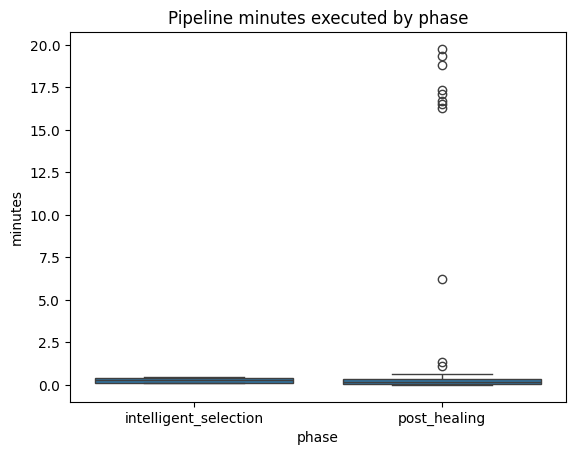

In [19]:
sns.boxplot(x="phase", y="minutes", data=agg)
plt.title("Pipeline minutes executed by phase")

In [20]:
# Skip rates

skip_summary = agg.groupby("phase")[["suites_run","suites_skipped"]].mean()
print(skip_summary)

                       suites_run  suites_skipped
phase                                            
intelligent_selection    3.380952        0.190476
post_healing             0.000000        0.000000


In [21]:
# Detection

fail_rates = agg.groupby("phase")["detected_fail"].mean()
print(fail_rates)

phase
intelligent_selection    0.52381
post_healing             0.43617
Name: detected_fail, dtype: float64


## 6. Statistical tests

In [22]:
minutes_all = agg.loc[agg["phase"]=="post_healing","minutes"]
minutes_its = agg.loc[agg["phase"]=="intelligent_selection","minutes"]

t_stat, p_val = ttest_ind(minutes_all, minutes_its, equal_var=False)
print("T-test minutes:", t_stat, p_val)

# Chi-square on detection
contingency = pd.crosstab(agg["phase"], agg["detected_fail"])
chi2, p, dof, exp = chi2_contingency(contingency)
print("Chi-square detection:", chi2, p)

T-test minutes: 2.9031382501354166 0.004608144695397742
Chi-square detection: 0.23723063284233487 0.6262134917526995


## 7. Visualize skipped vs run

Text(0.5, 1.0, 'Skipped suites per phase')

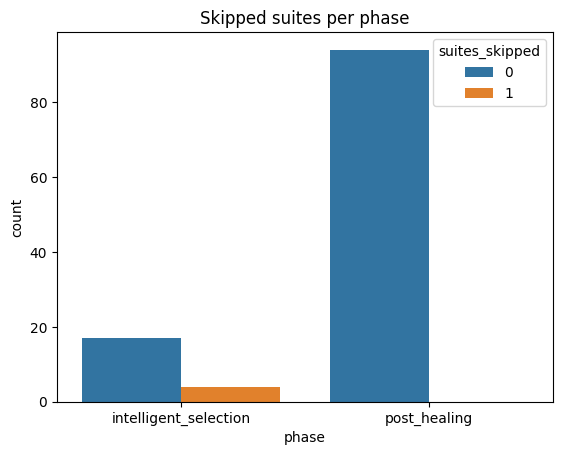

In [23]:
sns.countplot(x="phase", hue="suites_skipped", data=agg)
plt.title("Skipped suites per phase")

Text(0.5, 1.0, 'Suite outcomes by phase (pass/fail/skipped)')

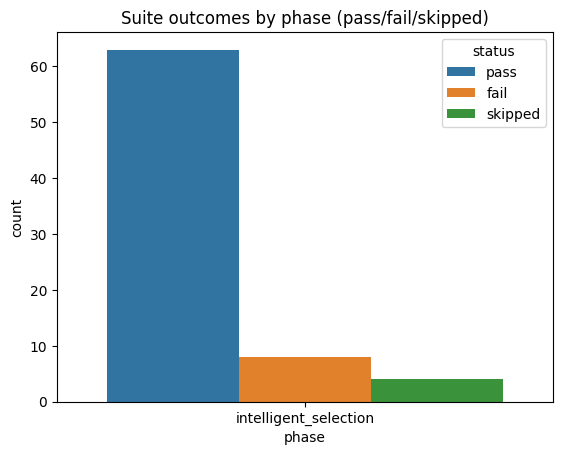

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only look at unit/functional rows
suites = df[df["tag"].isin(["unit","functional"])]

sns.countplot(x="phase", hue="status", data=suites)
plt.title("Suite outcomes by phase (pass/fail/skipped)")